### Matplotlib Exercises###

In this exercise we will write a class which will take a pandas dataframe and output a set of plots describing the dataframe. For this we will use data from http://earthquake.usgs.gov/ which maintains csv files corresponding to data of earthquake occurrences sorted according to earthquakes magnitude, ranging from significant only down to all earthquakes, major or minor. The csv files are available here 

In [5]:
feed="http://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/"

In [14]:
import numpy as np
import pandas as pd
import urllib2
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.basemap import Basemap
import matplotlib.animation as animation
%pylab inline
#%matplotlib nbagg

Populating the interactive namespace from numpy and matplotlib


Check if you have the updated version of Matplotlib i.e 1.5.0. If not you can udate it using linux command sudo pip install --upgrade matplotlib for unix boxes and corresponding brew command for mac

In [7]:
print mpl.__version__

1.5.0


### Acquiring Data ###

For this assignment we will be working with the following csv files

1. Significant earthquakes in the last 30 days : feed + "significant_month.csv"
2. Magnitude > 4.5 : feed + "4.5_month.csv"
3. Magnitude > 2.5 : feed + "2.5_month.csv"
4. Magnitude > 1.0 : feed + "1.0_month.csv"

Q1) Write a function which takes an integer input from 1 to 4 and outputs a pandas dataframe corresponding to the csv file above. Note that the function should necessarily download the data from the website via internet.

In [8]:
filenames=["significant_month.csv",
           "4.5_month.csv",
           "2.5_month.csv",
           "1.0_month.csv"]
def download_data(i):
    url=feed+filenames[i-1];
    print 'downloading',url
    return pd.read_csv(url);

In [9]:
last_30 = download_data(1)
data_45 = download_data(2)
data_25 = download_data(3)
data_10 = download_data(4)
last_30.head()

downloading http://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/significant_month.csv
downloading http://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/4.5_month.csv
downloading http://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/2.5_month.csv
downloading http://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/1.0_month.csv


,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,net,id,updated,place,type
0,2015-11-17T07:10:08.740Z,38.7548,20.5519,11.07,6.5,mwb,NaN,39,1.417,1.00,us,us10003ywp,2015-11-17T21:22:03.838Z,"14km WNW of Nidri, Greece",earthquake
1,2015-11-13T20:51:30.990Z,30.9915,128.8768,12.00,6.7,mww,NaN,17,1.445,1.13,us,us10003y71,2015-11-14T16:52:21.206Z,"140km WSW of Makurazaki, Japan",earthquake
2,2015-11-11T02:46:19.900Z,-29.4445,-72.1732,10.00,6.9,mww,NaN,33,0.940,1.53,us,us10003x9g,2015-11-13T06:15:19.359Z,"98km NW of Coquimbo, Chile",earthquake
3,2015-11-11T01:54:37.710Z,-29.4393,-72.1054,10.00,6.9,mww,NaN,39,0.893,1.53,us,us10003x8t,2015-11-11T15:28:23.143Z,"93km NW of Coquimbo, Chile",earthquake
4,2015-11-08T16:47:02.140Z,6.8456,94.6609,10.00,6.4,mwb,NaN,31,2.783,1.23,us,us10003vry,2015-11-09T04:37:22.000Z,"128km NW of Sabang, Indonesia",earthquake


###Q2) Analyzing the data ###

In order to understand the data we will plot different attributes of the data using tools provided by matplotlib.
In order to do that, we will first create a class object for the given dataframe.

2.1) The class will have a set of functions to generate different plots. The first function will output a histogram taking column type as input. The column type is restricted to latitude or longitude. Take default interval size as 10 degrees

2.2) Write another function which when called will output a scatter plot of longitude vs. latitude. For extra credit represent each earthquake by a circle whose area is proporportional to the strength of the earthquake.

In [11]:
last_30.columns

Index([u'time', u'latitude', u'longitude', u'depth', u'mag', u'magType',
       u'nst', u'gap', u'dmin', u'rms', u'net', u'id', u'updated', u'place',
       u'type'],
      dtype='object')

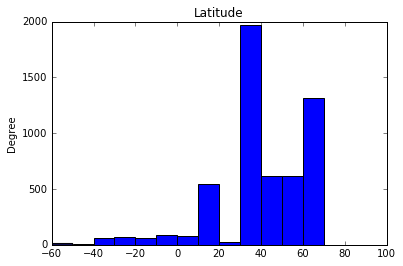

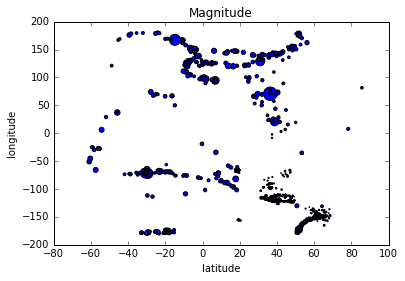

In [16]:
class dataPlot(object):
    """dataPlot takes a pandas dataframe as input and outputs different plots correspondng to the input dataframe"""
    
    def __init__(self, dataFrame):
        """Initialize variables"""
        self.dataFrame = dataFrame
        
    def histogram(self,colType):
        if colType in ['latitude', 'longitude']:
            figure()
            data=self.dataFrame[colType].values
            size=10
            plt.title(colType.title())
            self.dataFrame[colType].plot(kind='hist', bins=range(int(min(data)),int(max(data))+size,size))
        else:
            print 'colType must be latitude or longitude'
        
    def scatter(self):
        figure()
        x=self.dataFrame['latitude'].values
        y=self.dataFrame['longitude'].values
        magnitude=[np.exp(i)*0.1 for i in self.dataFrame['mag'].values]
        xlabel('latitude')
        ylabel('longitude')
        title('Magnitude')
        plt.scatter(x,y, s=magnitude)

p=dataPlot(data_10)
p.histogram('latitude')
p.scatter()

### Q3) Plotting data on the map ###

In the last class we had used basemap to plot the weather data. Now we will use basemap to plot the earthquake data, and further enhance it with a rain animation to indicate the severity of the incident. We will start initially with the dataset corresponding to earthquakes magnitude > 4.5

In [6]:
data_45 = download_data(2)

downloading http://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/4.5_month.csv


In [7]:
print data_45.shape

(400, 15)


First we will import necessary libraries

In [6]:
from mpl_toolkits.basemap import Basemap
import matplotlib.animation as animation

Next we will generate a figure canvas with a basemap projection. We will use the 'mill' projection of Basemap for this assignment. 

In [15]:
#General plot  initializations
fig = plt.figure(figsize=(10,10))
plt.title('Magnitude > 4.5', fontsize=20)
earth = Basemap(projection='mill')

We will then draw coastlines and continents

In [16]:
earth.drawcoastlines(color='0.50', linewidth=0.25)
earth.fillcontinents(color='0.95')

Now we will plot the magnitude of different earthquakes on the above plot according to the latitude and longitude of the origin and enhance it using Rain animation

#### Rain animation ####
A very simple rain effect can be obtained by having small growing rings randomly positioned over a figure. Of course, they won't grow forever since the wave is supposed to damp with time. To simulate that, we can use a more and more transparent color as the ring is growing, up to the point where it is no more visible. At this point, we remove the ring and create a new one.

An example from rain animation can be loaded by running the next cell (source: http://matplotlib.org/examples/animation/rain.html)

In [17]:
# %load rain.py

As you can see from the above code, the animation can be called from matplotlib's animation function using FuncAnimation or in our case animation.FuncAnimation. This will require an update function, a canvas fig, and an interval)

Q4) Now, based on the above rain animation, write an update function to plot the earthquake on earlier created fig. Set the interval as 10. i.e 
animation = animation.FuncAnimation(fig, update, interval=10)

To do this, create two objects rain_drops and scat as shown in the code above. The rain_drops and scat should be of the type as follows.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

magnitude=[np.exp(i)*0.1 for i in data_45['mag'].values]
lat=data_45['latitude'].values
lon=data_45['longitude'].values
pos=earth(lat,lon)
pos=zip(pos[0],pos[1])

# Create rain data
n_drops = 50
rain_drops = np.zeros(n_drops, dtype=[('position', float, 2),
                                      ('size',     float, 1),
                                      ('growth',   float, 1),
                                      ('color',    float, 4)])

# Initialize the raindrops for position and magnitude
rain_drops['position'] = pos[0]
rain_drops['growth'] = magnitude[0]

# Construct the scatter which we will update during animation
# as the raindrops develop.
scat = earth.scatter(rain_drops['position'][:, 0], rain_drops['position'][:, 1],
                  s=rain_drops['size'], lw=0.5, edgecolors=rain_drops['color'],
                  facecolors=rain_drops['color'], zorder='1')

Some of the key attributes for the plot should be set as follows
1. number of drops is 50
2. drop size is 5
3. growth is exponential with respect to magnitude i.e np.exp(magnitude) * 0.1
4. If magnitude less than 6 set color as 0,0,1,1 else set color as 1,0,0,1

The scat object functions 
1. set_edgecolors
2. set_sizes
3. set_offsets
4. set_faceColors

sets these values and returns the scat object. 

In [19]:
def update(frame_number):
    # Get an index which we can use to re-spawn the oldest raindrop.
    current_index = frame_number % n_drops
    
    # Make all colors more transparent as time progresses.
    rain_drops['color'][:, 3] -= 1.0/len(rain_drops)
    rain_drops['color'][:, 3] = np.clip(rain_drops['color'][:, 3], 0, 1)

    # Make all circles bigger.
    rain_drops['size'] += rain_drops['growth']

    
    rain_drops['position'][current_index] = pos[current_index]
    rain_drops['size'][current_index] = 5
    rain_drops['growth'][current_index] = magnitude[current_index]
    if rain_drops['growth'][current_index]<18:  #natural log of 6 times 10
        rain_drops['color'][current_index] = (0, 0, 1, 1)
    else:
        rain_drops['color'][current_index] = (1, 0, 0, 1)

    # Update the scatter collection, with the new colors, sizes and positions.
    scat.set_edgecolors(rain_drops['color'])
    scat.set_sizes(rain_drops['size'])
    scat.set_offsets(rain_drops['position'])
    scat.set_facecolor(rain_drops['color'])

Finally, plot the frames as an animation 

In [20]:
animation = FuncAnimation(fig, update, interval=10)
animation.save('basic_animation.mp4', extra_args=['-vcodec', 'libx264'])
animation.save('test.mp4')
plt.show()

#### Q4) Now, add this function to the above class dataPlot and call it for the dataframes data_25, data_1 ####

In [10]:
class dataPlot(object):
    """dataPlot takes a pandas dataframe as input and outputs different plots correspondng to the input dataframe"""
    
    def __init__(self, dataFrame):
        """Initialize variables"""
        self.dataFrame = dataFrame
        
    def histogram(self,colType):
        """Plot histogram"""
        if colType in ['latitude', 'longitude']:
            plt.figure()
            data=self.dataFrame[colType].values
            size=10
            plt.title(colType.title())
            self.dataFrame[colType].plot(kind='hist', bins=range(int(min(data)),int(max(data))+size,size))
        else:
            print 'colType must be latitude or longitude'
        
    def scatter(self):
        """Plot scatter plot"""
        plt.figure()
        x=self.dataFrame['latitude'].values
        y=self.dataFrame['longitude'].values
        magnitude=[np.exp(i)*0.1 for i in self.dataFrame['mag'].values]
        plt.xlabel('latitude')
        plt.ylabel('longitude')
        plt.title('Magnitude')
        plt.scatter(x,y, s=magnitude)
        
    def animate(self):
        """Animate Earthquare magnitudes on a map"""
        self.fig = plt.figure(figsize=(10,10))
        ax = self.fig.add_subplot(111)
        ax.set_title('Earthquakes', fontsize=20)
        earth = Basemap(projection='mill')
        earth.drawcoastlines(color='0.50', linewidth=0.25)
        earth.fillcontinents(color='0.95')
        #Parse data
        self.magnitude=[np.exp(i)*0.1 for i in self.dataFrame['mag'].values]
        self.lat=self.dataFrame['latitude'].values
        self.lon=self.dataFrame['longitude'].values
        pos=earth(self.lat,self.lon)
        self.pos=zip(pos[0],pos[1])
        # Create rain data
        self.n_drops = 50
        self.rain_drops = np.zeros(self.n_drops, dtype=[('position', float, 2),
                                              ('size',     float, 1),
                                              ('growth',   float, 1),
                                              ('color',    float, 4)])
        # Initialize the raindrops for position and magnitude
        self.rain_drops['position'] = self.pos[0]
        self.rain_drops['growth'] = self.magnitude[0]
        # Construct the scatter which we will update during animation
        # as the raindrops develop.
        self.scat = earth.scatter(self.rain_drops['position'][:, 0], self.rain_drops['position'][:, 1],
                          s=self.rain_drops['size'], lw=0.5, edgecolors=self.rain_drops['color'],
                          facecolors=self.rain_drops['color'], zorder='1')
        #Animation
        self.anim = FuncAnimation(self.fig, self.update, interval=10, blit=False)        
        #FFwriter = animation.FFMpegWriter()
        #self.anim.save('basic_animation.mp4', writer = FFwriter, fps=1, extra_args=['-vcodec', 'libx264'])
        plt.show()
        
    def update(self, frame_number):        
        # Get an index which we can use to re-spawn the oldest raindrop.
        current_index = frame_number % self.n_drops
        # Make all colors more transparent as time progresses.
        self.rain_drops['color'][:, 3] -= 1.0/len(self.rain_drops)
        self.rain_drops['color'][:, 3] = np.clip(self.rain_drops['color'][:, 3], 0, 1)
        # Make all circles bigger.
        self.rain_drops['size'] += self.rain_drops['growth']
        self.rain_drops['position'][current_index] = self.pos[current_index]
        self.rain_drops['size'][current_index] = 5
        self.rain_drops['growth'][current_index] = self.magnitude[current_index]
        if self.rain_drops['growth'][current_index]<18:  #natural log of 6 times 10
            self.rain_drops['color'][current_index] = (0, 0, 1, 1)
        else:
            self.rain_drops['color'][current_index] = (1, 0, 0, 1)
        # Update the scatter collection, with the new colors, sizes and positions.
        self.scat.set_edgecolors(self.rain_drops['color'])
        self.scat.set_sizes(self.rain_drops['size'])
        self.scat.set_offsets(self.rain_drops['position'])
        self.scat.set_facecolor(self.rain_drops['color'])
        return self.scat 

In [11]:
data_25.shape

(1387, 15)

In [12]:
D25 = dataPlot(data_25)

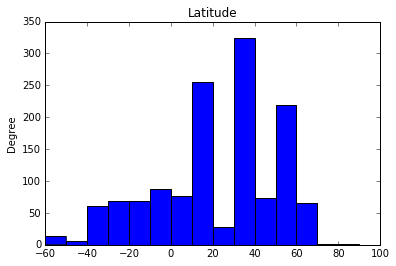

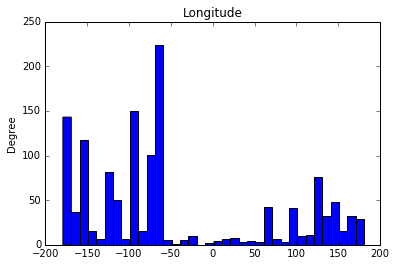

In [49]:
D25.histogram('latitude')
D25.histogram('longitude')

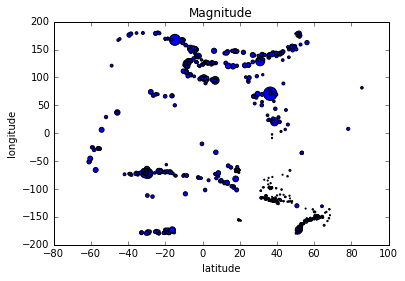

In [50]:
D25.scatter()

In [13]:
D25.animate()